### Importy

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

### Wczytanie danych

In [43]:
df = pd.read_csv("../data/final_data.csv", delimiter=';')
df.drop(columns=["id"], inplace=True)

### Dodatkowa analiza rozkładów i outlierów
Cel: Zidentyfikować i zrozumieć, które obserwacje ekstremalne (ceny > pewien próg) wypaczają odchylenie standardowe i R².

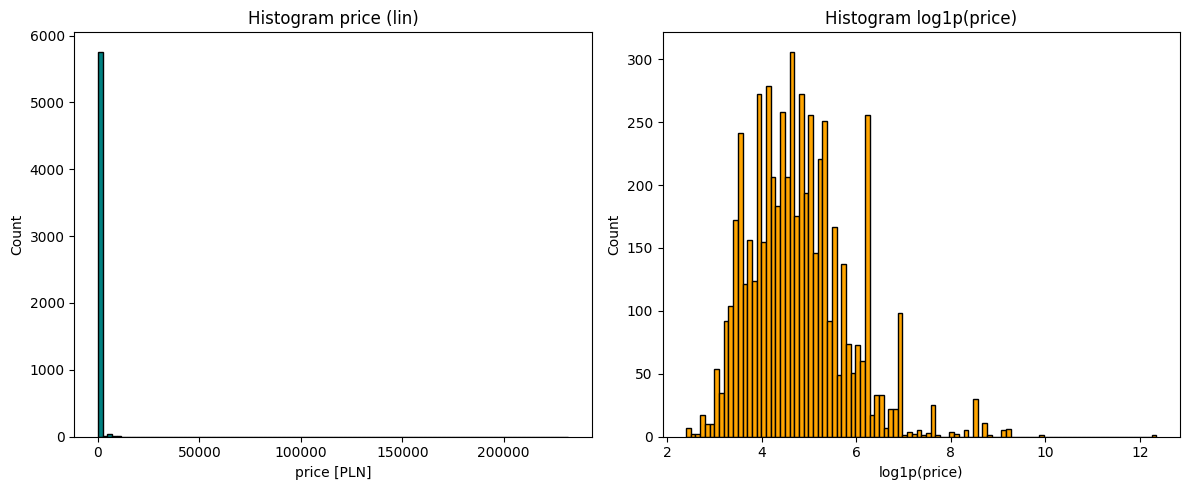

Price > 50 PLN: 76.47% obserwacji
Price > 100 PLN: 49.31% obserwacji
Price > 200 PLN: 23.62% obserwacji
Price > 300 PLN: 15.19% obserwacji
Price > 400 PLN: 11.72% obserwacji
Price > 500 PLN: 7.64% obserwacji
Price > 1000 PLN: 1.91% obserwacji
Price > 2000 PLN: 1.15% obserwacji
Price > 5000 PLN: 0.43% obserwacji


In [44]:
#Histogram cen w skali liniowej i logarytmicznej
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100, color='teal', edgecolor='black')
plt.title('Histogram price (lin)')
plt.xlabel('price [PLN]')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100, color='orange', edgecolor='black')
plt.title('Histogram log1p(price)')
plt.xlabel('log1p(price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Proporcja ofert powyżej różnych progów
for threshold in [50, 100, 200, 300, 400, 500, 1000, 2000, 5000]:
    pct = (df['price'] > threshold).mean() * 100
    print(f"Price > {threshold} PLN: {pct:.2f}% obserwacji")

### Korelacje cech z log1p(price) i wybór Top 50
Wytypowanie tych cech, które rzeczywiście silnie korelują z ceną – tak, aby nie trenować sieci na wszystkich ~190 kolumnach, tylko skupić się na 50–60 najbardziej znaczących atrybutach. Dzięki temu:

- Mniejsza liczba wejściowych zmiennych da mniej parametrów w sieci → szybsze trenowanie i mniejsze ryzyko overfittingu.

- Sieć nie będzie “rozpraszać się” na cechy niemające realnego wpływu na cenę.

Top 50 cech o najwyższej korelacji z log1p(price):
accommodates                        0.530
property_type_Private room in rental unit 0.507
room_type_Private room              0.468
room_type_Entire home/apt           0.449
property_type_Entire rental unit    0.404
bedrooms                            0.379
bathroom_type_shared                0.373
bathroom_type_unknown               0.324
amenity_Dishwasher                  0.317
amenity_Hair dryer                  0.306
instant_bookable                    0.292
amenity_Air conditioning            0.288
amenity_Lock on bedroom door        0.282
amenity_Crib                        0.274
beds                                0.261
amenity_Oven                        0.250
amenity_Hot water kettle            0.229
amenity_Toaster                     0.226
amenity_Microwave                   0.220
amenity_Coffee maker                0.219
amenity_Iron                        0.218
amenity_Bed linens                  0.217
amenity_Refrigerato

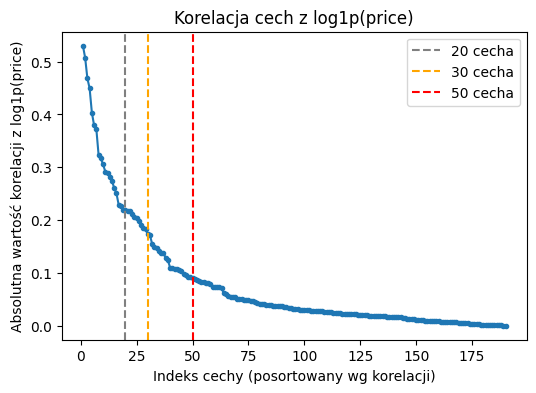

In [45]:
# Najpierw zapewniamy, że cena jest w logarytmie, bo rozkład jest mocno skośny:
price_log = np.log1p(df["price"])

# Obliczamy korelację bezwzględną każdej cechy z log1p(price)
# (pomijamy kolumny, których nie chcemy brać pod uwagę, np. 'id', samą 'price' czy 'is_premium')
corrs = []
for col in df.columns:
    if col in ["id", "price", "is_premium"]:
        continue
    # bierzemy tylko cechy numeryczne (float lub int)
    if pd.api.types.is_numeric_dtype(df[col]):
        # obliczamy korelację Pearsona między df[col] a price_log
        c = np.corrcoef(df[col], price_log, rowvar=False)[0, 1]
        corrs.append((col, abs(c)))

# Sortujemy według wartości korelacji malejąco i wyświetlamy top 20
corrs_sorted = sorted(corrs, key=lambda x: x[1], reverse=True)

print("Top 50 cech o najwyższej korelacji z log1p(price):")
for col, cval in corrs_sorted[:50]:
    print(f"{col:<35} {cval:.3f}")

# Następnie wybieramy, powiedzmy, Top 50 najbardziej skorelowanych cech
top_k = [col for col, _ in corrs_sorted[:50]]
print(f"\nWybrano {len(top_k)} cech jako Top 50.")

# Zapiszmy je do zmiennej X (będziemy trenować na tych cechach)
X = df[top_k].copy()

# A target (y) to log1p(price) (ew. price, jeśli będziesz trenować na surowych wartościach)
y = price_log.copy()

# Sprawdźmy rozmiary:
print("\nKształt X:", X.shape)
print("Kształt y:", y.shape)

# Przygotuj listę samych wartości korelacji w kolejności malejącej:
corr_values = [c for _, c in corrs_sorted]

plt.figure(figsize=(6,4))
plt.plot(range(1, len(corr_values)+1), corr_values, marker='o', markersize=3)
plt.axvline(20, color='gray', linestyle='--', label='20 cecha')
plt.axvline(30, color='orange', linestyle='--', label='30 cecha')
plt.axvline(50, color='red', linestyle='--', label='50 cecha')
plt.xlabel('Indeks cechy (posortowany wg korelacji)')
plt.ylabel('Absolutna wartość korelacji z log1p(price)')
plt.title('Korelacja cech z log1p(price)')
plt.legend()
plt.show()



### Opcje dla outlierów: segmentacja lub ważenie
Cel: Zdecydować, czy tworzyć osobne podejście dla „premium” ofert, czy ważyć stratę tak, by model zwracał większą uwagę na drogie ogłoszenia

In [46]:
# Definiujemy próg premium – na przykład >1000 PLN
premium_threshold = 1000

df['is_premium'] = (df['price'] > premium_threshold).astype(int)

print("Liczba premium ofert (>1000 PLN):", df['is_premium'].sum(), "/", len(df))
print(f"Udział: {df['is_premium'].mean() * 100:.2f}%")

Liczba premium ofert (>1000 PLN): 111 / 5826
Udział: 1.91%


### Podział danych, standaryzacja i przygotowanie tensorów

In [47]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Konwersja na tensory PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [48]:
# Wagi odwrotnie proporcjonalne do ceny (logarytmicznie skalowane)
weights = 1.0 / (1.0 + torch.exp(y_train_tensor - np.log1p(1000)))  # ceny > 1000 dostaną wagę bliską 0

# Dodanie do datasetu z wagami
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, weights)

In [49]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Prosty model sieci neuronowej

In [50]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = RegressionModel(input_dim)

### Trening modelu

In [51]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=100)

train_losses = []

for epoch in range(100):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch, w_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = (w_batch * (outputs - y_batch)**2).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    if epoch % 10 == 0 or epoch == 99:
        print(f"Epoch {epoch+1}/100, Loss: {epoch_loss:.4f}")

Epoch 1/100, Loss: 12.1621
Epoch 11/100, Loss: 0.2806
Epoch 21/100, Loss: 0.2809
Epoch 31/100, Loss: 0.2457
Epoch 41/100, Loss: 0.1929
Epoch 51/100, Loss: 0.1340
Epoch 61/100, Loss: 0.1050
Epoch 71/100, Loss: 0.0684
Epoch 81/100, Loss: 0.0453
Epoch 91/100, Loss: 0.0341
Epoch 100/100, Loss: 0.0316


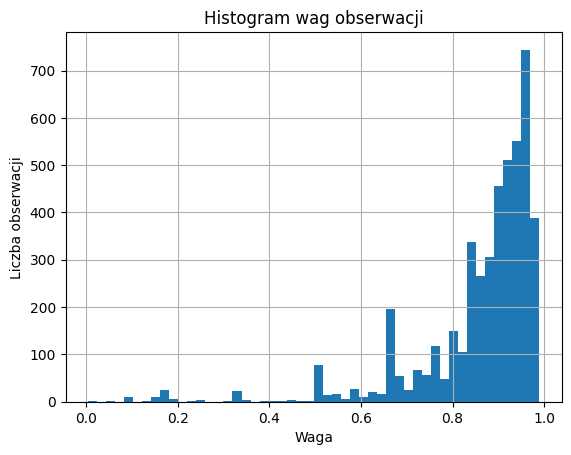

In [52]:
plt.hist(weights.numpy(), bins=50)
plt.title("Histogram wag obserwacji")
plt.xlabel("Waga")
plt.ylabel("Liczba obserwacji")
plt.grid(True)
plt.show()

### Wykres loss

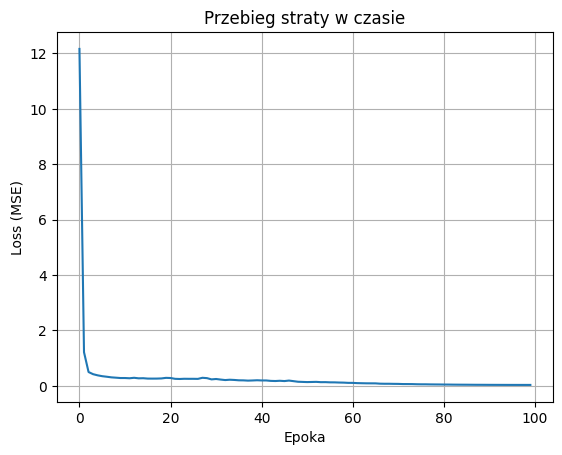

In [53]:
plt.plot(train_losses)
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.title("Przebieg straty w czasie")
plt.grid(True)
plt.show()

### Ewaluacja metryk (MAE, RMSE, R²)

In [54]:
# Przełączenie modelu w tryb ewaluacji
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Konwersja do NumPy
y_pred = y_pred_tensor.squeeze().numpy()
y_true = y_test_tensor.squeeze().numpy()

# Metryki
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

MAE:  0.56
RMSE: 0.78
R²:   0.3495


### Wykres Predykcja vs Rzeczywistość

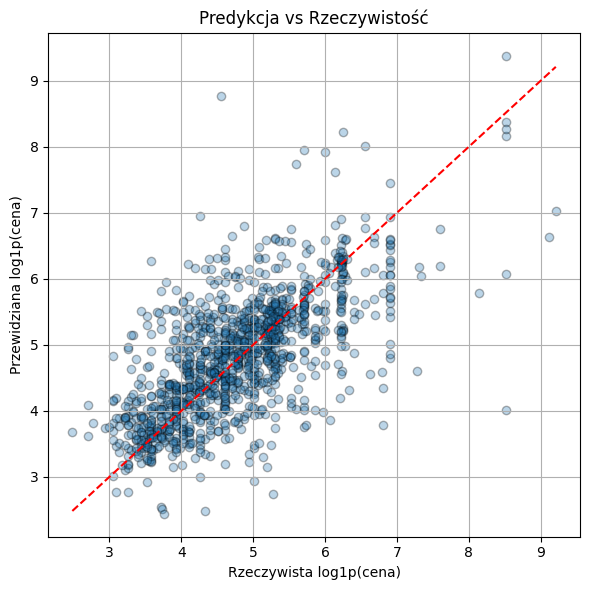

In [55]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.3, edgecolor='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Rzeczywista log1p(cena)")
plt.ylabel("Przewidziana log1p(cena)")
plt.title("Predykcja vs Rzeczywistość")
plt.grid(True)
plt.tight_layout()
plt.show()